In [1]:
import warnings

warnings.filterwarnings("ignore")
from pathlib import Path

# Scientific and datavis stack
import iris.cube
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import ticker
# My packages and local scripts
from aeolus.calc import time_mean
from aeolus.const import init_const
from aeolus.coord import isel
from aeolus.core import AtmoSim
from aeolus.io import load_data, load_vert_lev
from aeolus.model import um
from aeolus.plot import add_custom_legend, subplot_label_generator, tex2cf_units
from aeolus.region import Region
from aeolus.synthobs import (
    calc_stellar_flux,
    calc_transmission_spectrum,
    read_normalized_stellar_flux,
    read_spectral_bands,
)

In [2]:
warnings.filterwarnings("ignore", module="iris")
plt.rcParams["mathtext.default"] = "regular"

In [3]:
# Note that the file paths should be pathlib.Path-like objects, not just plain strings!
DATA_DIR = Path.home().parent.parent/ "data" / "mz355" / "um_runs" / "wasp96b" / "kinetics" / "u-cp238" / "raw" / "atmos_base_1001" 
DATA_DIR_eq = Path.home().parent.parent/ "data" / "mz355" / "um_runs" / "wasp96b" / "equilibrium" / "u-cp158" / "raw" / "atmos_base_1001" 

#/data/mz355/um_runs/wasp96b/kinetics/u-cp238/raw/atmos_base_1000

In [4]:
SPECTRUM_DIR = Path.home().parent.parent/ "data" / "mz355" / "um_inputs" / "planets" /  "wasp96b" /  "spectral_files"

spectral_file = SPECTRUM_DIR / "spec_file_wasp96b_mdh0_sw_500"
data_file = DATA_DIR / "atmosa.ph0000001000_00_day"
pd0 = iris.load(data_file)

#2hr_mdh1_day/atmos_base_0000

print(pd0)
planet_transmission_day = pd0.extract_cube("m01s01i755")


# To keep the units of stellar and planetary parameters, store the parameters as iris cubes
stellar_constant_at_1_au = iris.cube.Cube(
    1275.359867, units="W m-2", long_name="stellar_constant_at_1_au"
)
stellar_radius = iris.cube.Cube(7.31e8, units="m", long_name="stellar_radius")
planet_radius = iris.cube.Cube(83893200, units="m", long_name="planet_radius")
planet_domain_height = iris.cube.Cube(9737675.52477816, units="m", long_name="height_domain")
planet_top_of_atmosphere = planet_radius + planet_domain_height

0: m01s01i755 / (unknown)              (pseudo_level: 500; latitude: 90; longitude: 144)


In [5]:
morning_constraint = Region(180, 360, -90, 90).constraint
western_terminator = planet_transmission_day.extract(morning_constraint)

In [6]:
print(planet_transmission_day.shape)
print(western_terminator.shape)

(500, 90, 144)
(500, 90, 72)


In [7]:
evening_constraint = Region(0,180,-90,90).constraint
eastern_terminator = planet_transmission_day.extract(evening_constraint)

In [8]:
print(eastern_terminator.shape)

(500, 90, 72)


In [9]:

spectral_file = SPECTRUM_DIR / "spec_file_wasp96b_mdh0_sw_500"
data_file_eq = DATA_DIR_eq / "atmosa.ph0000001000_00_day"
pd0_eq = iris.load(data_file_eq)

#2hr_mdh1_day/atmos_base_0000

print(pd0_eq)
planet_transmission_day_eq = pd0_eq.extract_cube("m01s01i755")


# To keep the units of stellar and planetary parameters, store the parameters as iris cubes
stellar_constant_at_1_au = iris.cube.Cube(
    1275.359867, units="W m-2", long_name="stellar_constant_at_1_au"
)
stellar_radius = iris.cube.Cube(7.31e8, units="m", long_name="stellar_radius")
planet_radius = iris.cube.Cube(83893200, units="m", long_name="planet_radius")
planet_domain_height = iris.cube.Cube(9737675.52477816, units="m", long_name="height_domain")
planet_top_of_atmosphere = planet_radius + planet_domain_height

0: m01s01i755 / (unknown)              (pseudo_level: 500; latitude: 90; longitude: 144)


In [10]:
western_terminator_eq = planet_transmission_day_eq.extract(morning_constraint)
eastern_terminator_eq = planet_transmission_day_eq.extract(evening_constraint)

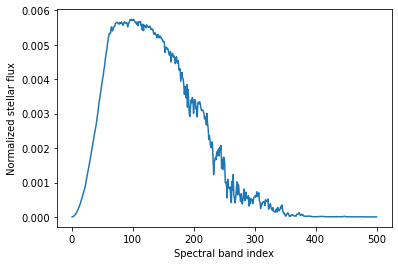

In [11]:
normalized_stellar_flux = read_normalized_stellar_flux(spectral_file)

plt.plot(
    normalized_stellar_flux.coord("spectral_band_index").points,
    normalized_stellar_flux.data,
)
plt.xlabel("Spectral band index")
plt.ylabel("Normalized stellar flux");

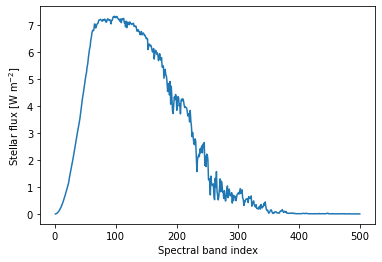

In [12]:
stellar_flux = calc_stellar_flux(spectral_file, stellar_constant_at_1_au)

plt.plot(stellar_flux.coord("spectral_band_index").points, stellar_flux.data)
plt.xlabel("Spectral band index")
plt.ylabel("Stellar flux [W $m^{-2}$]");

In [13]:
rp_eff_over_rs_western = calc_transmission_spectrum(
    western_terminator,
    spectral_file,
    stellar_constant_at_1_au,
    stellar_radius,
    planet_top_of_atmosphere,
    model=um,
)
rp_eff_over_rs_eastern = calc_transmission_spectrum(
    eastern_terminator,
    spectral_file,
    stellar_constant_at_1_au,
    stellar_radius,
    planet_top_of_atmosphere,
    model=um,
)

In [14]:
rp_eff_over_rs_western_eq = calc_transmission_spectrum(
    western_terminator_eq,
    spectral_file,
    stellar_constant_at_1_au,
    stellar_radius,
    planet_top_of_atmosphere,
    model=um,
)
rp_eff_over_rs_eastern_eq = calc_transmission_spectrum(
    eastern_terminator_eq,
    spectral_file,
    stellar_constant_at_1_au,
    stellar_radius,
    planet_top_of_atmosphere,
    model=um,
)

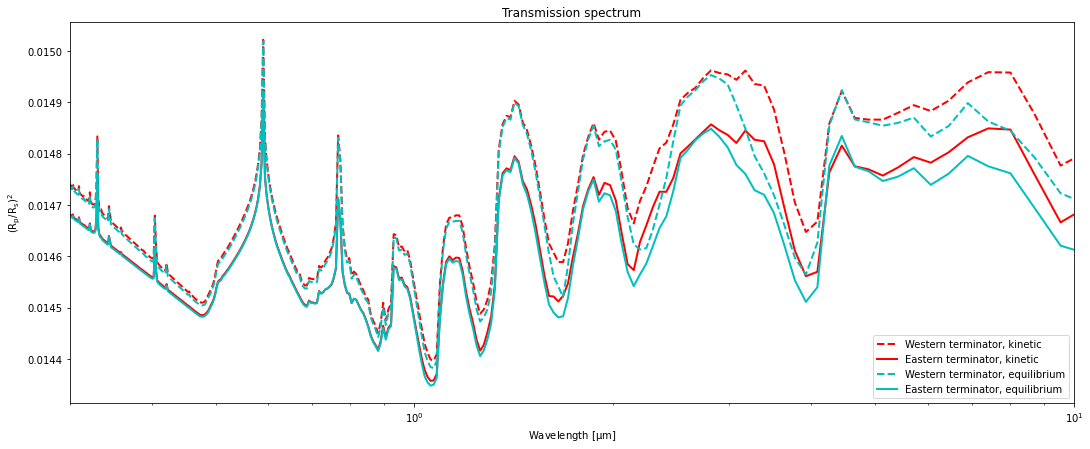

In [20]:
fig, ax = plt.subplots(figsize=(18, 7))

ax.plot(
        rp_eff_over_rs_western.coord("spectral_band_centres").points * 1e6,
        rp_eff_over_rs_western.data**2-0.0012,
        label="Western terminator, kinetic",
        linewidth=2,
        alpha=1,
        linestyle = "--",
        color = "r"
    )
ax.plot(
        rp_eff_over_rs_eastern.coord("spectral_band_centres").points * 1e6,
        rp_eff_over_rs_eastern.data**2-0.0012,
        label="Eastern terminator, kinetic",
        linewidth=2,
        alpha=1,
        linestyle = "-",
        color = "r"
    )
ax.plot(
        rp_eff_over_rs_western_eq.coord("spectral_band_centres").points * 1e6,
        rp_eff_over_rs_western_eq.data**2-0.0012,
        label="Western terminator, equilibrium",
        linewidth=2,
        alpha=1,
        linestyle = "--",
        color = "c"
    )
ax.plot(
        rp_eff_over_rs_eastern_eq.coord("spectral_band_centres").points * 1e6,
        rp_eff_over_rs_eastern_eq.data**2-0.0012,
        label="Eastern terminator, equilibrium",
        linewidth=2,
        alpha=1,
        linestyle = "-",
        color = "c"
    )

ax.set_title("Transmission spectrum")
ax.set_xlabel("Wavelength [$\mu$m]")
ax.set_ylabel("($R_p/R_s)^2$")
ax.set_xscale("log")
ax.set_xlim(0.3, 10)


ax.legend(loc="lower right")
plt.savefig("terminators.png")

In [16]:
# NIGHT_DIR = Path.home().parent.parent/ "data" / "mz355" / "um_runs" / "wasp96b" / "kinetics" / "u-cp238" / "raw" / "atmos_base_1001" 
# night_file = NIGHT_DIR / "atmosa.ph0000001000_00_night"

# night_cubes = iris.load(night_file)

# #2hr_mdh1_day/atmos_base_0000

# planet_transmission_night = night_cubes.extract_cube("m01s01i755")

In [17]:
# NIGHT_DIR_eq = Path.home().parent.parent/ "data" / "mz355" / "um_runs" / "wasp96b" / "equilibrium" / "u-cp158" / "raw" / "atmos_base_1001" 
# night_file_eq = NIGHT_DIR_eq / "atmosa.ph0000001000_00_night"

# night_cubes_eq = iris.load(night_file_eq)

# #2hr_mdh1_day/atmos_base_0000

# planet_transmission_night_eq = night_cubes_eq.extract_cube("m01s01i755")

In [18]:
# rp_eff_over_rs_night = calc_transmission_spectrum(
#     planet_transmission_night,
#     spectral_file,
#     stellar_constant_at_1_au,
#     stellar_radius,
#     planet_top_of_atmosphere,
#     model=um,
# )

# rp_eff_over_rs_night_eq = calc_transmission_spectrum(
#     planet_transmission_night_eq,
#     spectral_file,
#     stellar_constant_at_1_au,
#     stellar_radius,
#     planet_top_of_atmosphere,
#     model=um,
# )

In [19]:
# fig, ax = plt.subplots(figsize=(15, 7))
# # axins = ax.inset_axes([0.7, 0.7, 0.25, 0.25])
# # axins.set_xlim(5, 6)
# # axins.set_ylim(0.0155, 0.0157)
# for _ax in (ax, axins):
#     _ax.plot(
#         rp_eff_over_rs_day_eq.coord("spectral_band_centres").points * 1e6,
#         rp_eff_over_rs_day_eq.data**2-0.0012,
#         label="Equilibrium day-night average",
#         linewidth=2,
#         alpha=1,
#         linestyle = "--"
#     )
#     # _ax.plot(
#     #     rp_eff_over_rs_night.coord("spectral_band_centres").points * 1e6,
#     #     rp_eff_over_rs_night.data**2,
#     #     label="Nightside",
#     #     linewidth=1,
#     #     alpha=1,
#     #     linestyle = "--"
#     # )
#     _ax.plot(
#         rp_eff_over_rs_dn.coord("spectral_band_centres").points * 1e6,
#         rp_eff_over_rs_dn.data**2-0.0012,
#         label="Kinetic day-night average",
#         linewidth=2,
#         alpha = 1
        
#     )

# ax.set_title("Transmission spectrum")
# ax.set_xlabel("Wavelength [$\mu$m]")
# ax.set_ylabel("($R_p/R_s)^2$")
# ax.set_xscale("log")
# ax.set_xlim(0.3, 3)

# # xticks = np.concatenate(
# #     [
# #         np.arange(1, 11, 1),
# #         np.arange(15, 35, 5),
# #         np.arange(40, 120, 20),
# #         np.arange(500, 1400, 500),
# #         np.arange(10000, 10001, 500),
# #     ]
# # )
# # ax.set_xticks(xticks)
# # ax.set_xticklabels(xticks)
# # ax.indicate_inset_zoom(axins, edgecolor="black")
# ax.legend(loc="lower right")